# TISSUE multiple imputation framework using SpatialDE (spatially variable gene detection)

This notebook contains code for generating figures showing TISSUE multiple imputation hypothesis testing using the SpatialDE test for spatially variable gene detection and Licht-Rubin transformation of the p-value (less rigorous than Rubin's rules used for the t-test). It relies on the outputs of the `get_multi_spatialde.py` script with parameters in `run_dgea_spatialde.slurm`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal
from statsmodels.stats.multitest import multipletests

from TISSUE.tissue.main import *
from TISSUE.tissue.downstream import *
from TISSUE.tissue.experiments import *

from scipy.stats import mannwhitneyu

import SpatialDE
import NaiveDE

In [2]:
# Mapping to detailed descriptors

dataset_mapper = {"Dataset3": "Mouse Hipp.\n(seqFISH)",
                  "Dataset9": "Mouse VISP\n(MERFISH)",
                  "Dataset11": "Mouse PC\n(STARmap)", 
                  "Dataset12": "Human MTG\n(ISS)",
                  "Dataset13": "Mouse VISP\n(ISS)",
                  "Dataset14": "Drosophila Embryo\n(FISH)",
                  "Dataset15": "Mouse SC\n(osmFISH)",
                  "Dataset17": "Mouse VISP\n(ExSeq)",
                  "Axolotl": "Axolotl Brain\n(Stereo-seq)",
                  "Dataset7": "Human U2OS\n(MERFISH)",
                  "Dataset1": "Mouse Gast.\n(seqFISH)"}

method_mapper = {"tangram": "Tangram",
                 "spage": "SpaGE",
                 "knn": "Harmony",
                 "gimvi": "gimVI"}

## Read in output anndata objects and combine into results dict

In [4]:
# Generate dictionary of results from the AnnData objects

dataset_names = ["Dataset11","Dataset17"]


##################
combined_stat_result_dict = {}

for i in range(len(dataset_names)):

    dataset_name=dataset_names[i]
    
    # read result anndata object
    adata = sc.read_h5ad(f'scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/{dataset_name}_knn_spage_tangram_MI_SPATIALDE.h5ad')

    combined_stat_result_dict[dataset_name] = {}

    for method in ["spage", "tangram", "knn"]:

        # init subdict
        combined_stat_result_dict[dataset_name][method] = {}
        key = "spatialde"
        combined_stat_result_dict[dataset_name][method][key] = {}
        combined_stat_result_dict[dataset_name][method][key]["gene"] = adata.var_names.values
        
        # add TISSUE results from var 
        var_key = method+"_"+key
        combined_stat_result_dict[dataset_name][method][key]["mi_pvalue"] = adata.var[var_key+"_pvalue"].values

        # test with measured values
        normalized_matrix = adata.X/(1+np.sum(adata.X,axis=1)[:,None])
        normalized_matrix = np.log((normalized_matrix-np.min(normalized_matrix)+1) * 100)                           
        df = pd.DataFrame(normalized_matrix,
                          columns=adata.var_names,
                          index=adata.obs_names)
        results = SpatialDE.run(adata.obsm['spatial'],df)
        results.g = results.g.astype("category")
        results.g = results.g.cat.set_categories(adata.var_names)
        results = results.sort_values(["g"])
        pp = results["pval"]
        combined_stat_result_dict[dataset_name][method][key]["true_pvalue"] = pp
        
        # test with predicted values (baseline)
        X = adata.obsm[method+"_predicted_expression"][adata.var_names].values
        normalized_matrix = X/(1+np.sum(X,axis=1)[:,None])
        normalized_matrix = np.log((normalized_matrix-np.min(normalized_matrix)+1) * 100)  
        df = pd.DataFrame(normalized_matrix,
                          columns=adata.var_names,
                          index=adata.obs_names)
        results = SpatialDE.run(adata.obsm['spatial'],df)
        results.g = results.g.astype("category")
        results.g = results.g.cat.set_categories(adata.var_names)
        results = results.sort_values(["g"])
        pp = results["pval"]
        combined_stat_result_dict[dataset_name][method][key]["imp_pvalue"] = pp

# pickle dict
# with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_spatialde.pkl", "wb") as f:
#     pickle.dump(combined_stat_result_dict, f)

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

## FDR plots comparing TISSUE to baseline

/tmp/ipykernel_47/2579573175.py:64: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
/tmp/ipykernel_47/2579573175.py:65: RuntimeWarning: invalid value encountered in long_scalars
  fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))


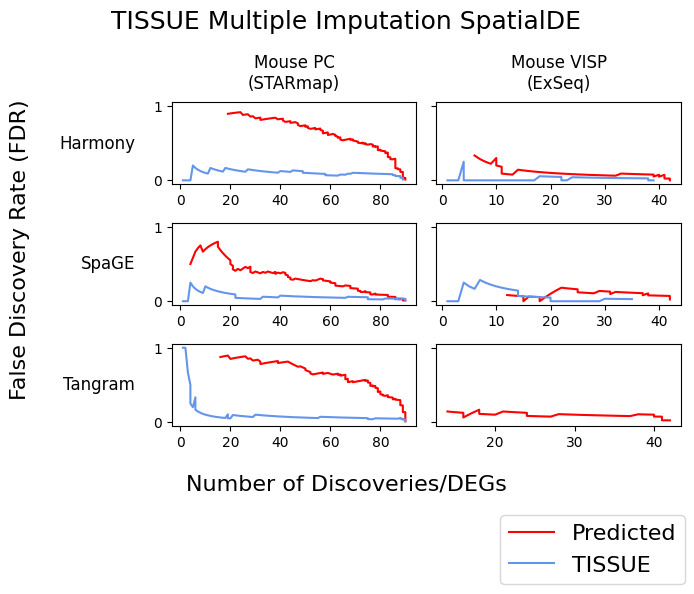

In [3]:
# IMPUTED VS TRUE COMPARISONS

dataset_names = ["Dataset11", "Dataset17"]
methods = ["knn", "spage", "tangram"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_spatialde.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(7,5), sharex=False, sharey=True)
    
    
    
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        num_pos_1 = []
        num_pos_2 = []
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            # add number of discoveries
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        
        axs[i,j].plot(num_pos_1, fdr_list_1, color='r', label="Predicted")
        axs[i,j].plot(num_pos_2, fdr_list_2, color='cornflowerblue', label="TISSUE")

# legend
fig.legend(["Predicted", "TISSUE"], loc='center right', ncol=1, bbox_to_anchor=(1,-0.1), bbox_transform=fig.transFigure, fontsize=16)
        
        
# axis labels
fig.suptitle("TISSUE Multiple Imputation SpatialDE",fontsize=18)
fig.supxlabel("Number of Discoveries/DEGs", fontsize=16)
fig.supylabel("False Discovery Rate (FDR)", fontsize=16)
        
# set row and column headers
cols = [dataset_mapper[d] for d in list(dataset_names)]
rows = [method_mapper[m] for m in list(methods)]
padrow = 5
padcol = 10
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, padcol),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padrow, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
plt.tight_layout()
plt.savefig("plots/scpi_dgea/SPATIALDE_paneled_pvalue_numpositives_fdr_curves.pdf", bbox_inches='tight')
plt.show()

### TISSUE-specific discoveries (Unc13c gene)

In [78]:
# comparing exclusive TISSUE vs baseline discoveries / false discoveries

df = pd.DataFrame.from_dict(combined_stat_result_dict['Dataset17']['spage']['spatialde'])

cutoff = 0.05

df_tissue_discovered = df[(df['mi_pvalue']<cutoff)&(df["true_pvalue"]<cutoff)&(df["imp_pvalue"]>cutoff)]
df_false_discovered = df[(df['mi_pvalue']>cutoff)&(df["true_pvalue"]>cutoff)&(df["imp_pvalue"]<cutoff)]

In [86]:
for x in df_tissue_discovered['gene'].values:
    print(x)
df_tissue_discovered

unc13c


,gene,mi_pvalue,true_pvalue,imp_pvalue
38,unc13c,0.000066,0.037254,0.082181


/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


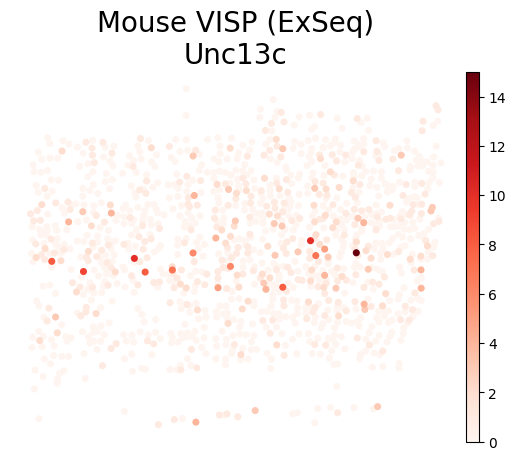

In [88]:
# Spatial visualization of measured Unc13c expression

dataset_name = "Dataset17"
gene = "Unc13c"

dataset_mapper = {"Dataset3": "Mouse Hipp. (seqFISH)",
                  "Dataset9": "Mouse VISP (MERFISH)",
                  "Dataset11": "Mouse PC (STARmap)", 
                  "Dataset12": "Human MTG (ISS)",
                  "Dataset13": "Mouse VISP (ISS)",
                  "Dataset14": "Drosophila Embryo (FISH)",
                  "Dataset15": "Mouse SC (osmFISH)",
                  "Dataset17": "Mouse VISP (ExSeq)",
                  "Axolotl": "Axolotl Brain (Stereo-seq)",
                  "Dataset7": "Human U2OS (MERFISH)",
                  "Dataset1": "Mouse Gast. (seqFISH)"}


adata = load_spatial_data("DataUpload/"+dataset_name+"/Spatial_count.txt",
                             "DataUpload/"+dataset_name+"/Locations.txt")

# make plot
#sc.set_figure_params(vector_friendly=True, dpi=500, figsize=(7,5), fontsize=16)
sc.pl.embedding(adata, "spatial", color=gene, cmap="Reds", show=False)
plt.title(dataset_mapper[dataset_name]+"\n"+gene.capitalize(), fontsize=20)
plt.axis('off')
plt.savefig(f"plots/SpatialDE_{dataset_name}_{gene}.pdf", bbox_inches="tight", dpi=300)
plt.show()

### Printing specific values for supplementary table

In [ ]:
# Print out values for Supplementary Table 2

dataset_names = ["Dataset11", "Dataset17"]
methods = ["knn", "spage", "tangram"]
xlab = "true_pvalue"
ylab1 = "imp_pvalue"
ylab2 = "mi_pvalue"

proportion_discoveries = 0.4

###############################################
with open(f"results/hypothesis_testing/{'_'.join(dataset_names)}_spatialde.pkl", "rb") as input_file:
    combined_stat_result_dict = pickle.load(input_file)

# get nrows and ncols
n2 = len(list(combined_stat_result_dict.keys()))
n1 = len(list(combined_stat_result_dict[list(combined_stat_result_dict.keys())[0]].keys()))

# P-VALUE

fig, axs = plt.subplots(n1, n2, figsize=(7,5), sharex=False, sharey=True)
    
    
    
for j, dataset in enumerate(dataset_names):
            
    for i, method in enumerate(methods):
        
        # collect all comparisons
        agg_x = np.array([])
        agg_y1 = np.array([])
        agg_y2 = np.array([])
        for g1 in combined_stat_result_dict[dataset][method].keys():
            agg_x = np.concatenate((agg_x, combined_stat_result_dict[dataset][method][g1][xlab]))
            agg_y1 = np.concatenate((agg_y1, combined_stat_result_dict[dataset][method][g1][ylab1]))
            agg_y2 = np.concatenate((agg_y2, combined_stat_result_dict[dataset][method][g1][ylab2]))
        
        num_pos_1 = []
        num_pos_2 = []
        
        fdr_list_1 = []
        fdr_list_2 = []
        
        # make pvalue array to search be all pvalues across agg_x, agg_y1, agg_y2 [most efficient search]
        p_cutoff_uncorrected_arr = np.sort(np.concatenate(([-1],agg_x,agg_y1,agg_y2)))
        
        for p_cutoff_uncorrected in np.float128(p_cutoff_uncorrected_arr):
            
            # get positive hits
            true_labels = np.float128(agg_x) < p_cutoff_uncorrected
            imp_labels = np.float128(agg_y1) < p_cutoff_uncorrected
            mi_labels = np.float128(agg_y2) < p_cutoff_uncorrected

            # make confusion matrix
            confusion_matrix_1 = np.array([[np.sum(true_labels[true_labels]==imp_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=imp_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=imp_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==imp_labels[~true_labels])]])
            
            confusion_matrix_2 = np.array([[np.sum(true_labels[true_labels]==mi_labels[true_labels]),
                                          np.sum(true_labels[true_labels]!=mi_labels[true_labels])],
                                          [np.sum(true_labels[~true_labels]!=mi_labels[~true_labels]),
                                           np.sum(true_labels[~true_labels]==mi_labels[~true_labels])]])
            
            # compute FDR
            fdr_list_1.append(confusion_matrix_1[1,0]/(confusion_matrix_1[1,0]+confusion_matrix_1[0,0]))
            fdr_list_2.append(confusion_matrix_2[1,0]/(confusion_matrix_2[1,0]+confusion_matrix_2[0,0]))
            
            # add number of discoveries
            num_pos_1.append(np.nansum(imp_labels))
            num_pos_2.append(np.nansum(mi_labels))
        
        
        # threshold to report FDR for
        cut_idx1 = (np.abs(np.array(num_pos_1)-round(len(agg_x)*proportion_discoveries))).argmin()
        cut_idx2 = (np.abs(np.array(num_pos_2)-round(len(agg_x)*proportion_discoveries))).argmin()
        print(dataset)
        print(method)
        print(fdr_list_2[cut_idx2])
        print(fdr_list_1[cut_idx1])
        print("")